In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import re
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob

Lendo o dataset. Dataset pode ser encontrado https://raw.githubusercontent.com/iRitiLopes/mdados_projeto_ufabc_qs.2021/main/vaccination_tweets.csv

In [6]:
dataframe = pd.read_csv("https://raw.githubusercontent.com/iRitiLopes/mdados_projeto_ufabc_qs.2021/main/vaccination_tweets.csv")
dataframe.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


# Preparaçao dos dados
Neste trecho preparamos os dados referentes a datas, criando uma nova cluna para o dia de hoje e então calculamos quanto tempo em anos o registro no CSV referente a conta do usuário possui.

In [7]:
from datetime import date
dataframe['today']=date.today()
dataframe['user_created']=pd.to_datetime(dataframe['user_created']).dt.year
dataframe['today']=pd.to_datetime(dataframe['today'])
dataframe['today']=dataframe['today'].dt.year
dataframe['acc_age']= dataframe['today']-dataframe['user_created']
dataframe['date']=pd.to_datetime(dataframe['date'])
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
dataframe = dataframe.join(pd.concat((getattr(dataframe['date'].dt, i).rename(i) for i in L), axis=1))
dataframe.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,today,acc_age,year,month,day,dayofweek,dayofyear,weekofyear,quarter
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,2021,12,2020,12,20,6,355,51,4
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,2021,12,2020,12,13,6,348,50,4
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2021,1,2020,12,12,5,347,50,4
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,2021,13,2020,12,12,5,347,50,4
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2021,1,2020,12,12,5,347,50,4


Split da coluna user_location. Não segue um padrão especifico. Mas a grande maioria respeita Cidade, País. Splitamos por `,` e então traduzimos alguns textos que representam no caso a Provincia/Estado para o país de origem

In [10]:
dataframe[["first_loc", "second_loc"]] = dataframe["user_location"].str.split(',', expand=True)[[0,1]]
dataframe['second_loc'] = dataframe['second_loc'].str.strip()
state_fix = {
    'Ontario': 'Canada',
    'United Arab Emirates': 'UAE',
    'TX': 'USA',
    'NY': 'USA',
    'FL': 'USA',
    'England': 'UK',
    'Watford': 'UK',
    'United Kingdom': 'UK',
    'GA': 'USA',
    'IL': 'USA',
    'Alberta': 'Canada',
    'WA': 'USA',
    'NC': 'USA',
    'British Columbia': 'Canada',
    'MA': 'USA',
    'ON':'Canada',
    'OH':'USA',
    'MO':'USA',
    'AZ':'USA',
    'NJ':'USA',
    'CA':'USA',
    'DC':'USA',
    'AB':'USA',
    'PA':'USA',
    'SC':'USA',
    'VA':'USA',
    'TN':'USA',
    'New York':'USA',
    'Dubai':'UAE',
    'CO':'USA',
    'BC - Canada': 'CA',
    np.nan: None
  }
dataframe = dataframe.replace({"second_loc": state_fix})
dataframe['second_loc'].value_counts()[:40]

USA                        860
UK                         615
Canada                     183
India                      178
Ireland                     90
UAE                         77
Germany                     61
Belgium                     26
France                      24
South Africa                23
Scotland                    22
Pakistan                    19
Qatar                       17
London                      17
MI                          16
New South Wales             16
Deutschland                 16
Malaysia                    16
Australia                   15
Nederland                   14
Switzerland                 14
a spot in this Universe     14
Spain                       12
Italy                       11
California                  11
Wales                       10
Greece                      10
Philippines                 10
Queensland                   9
BC                           9
CT                           9
Turkey                       9
WI      

Discretização da quantidades de seguidores do usuário.


1.   x < 100 = Weak
2.   100 <= x < 1000 = Norm
3.   1000 < x <= 10000 = Strong
4.   Acima = Influencer

In [11]:
dataframe['acc_class'] = dataframe['user_followers'].apply(
    lambda x:'weak'if x<=100 else ('norm' if 1000>=x>100 else ('strong' if 10000>=x>1000 else 'influencer')))
dataframe.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,today,acc_age,year,month,day,dayofweek,dayofyear,weekofyear,quarter,first_loc,second_loc,acc_class
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,2021,12,2020,12,20,6,355,51,4,La Crescenta-Montrose,USA,norm
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,2021,12,2020,12,13,6,348,50,4,San Francisco,USA,norm
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2021,1,2020,12,12,5,347,50,4,Your Bed,None,weak
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,2021,13,2020,12,12,5,347,50,4,Vancouver,CA,influencer
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2021,1,2020,12,12,5,347,50,4,NaN,None,norm


Limpeza e preparação dos tweets

*   Remover links
*   Remover hashtags
*   Remover menções a outros usuários
*   Remover caracteres sozinhos (Stop words)
*   Remover excesso de espaços
*   Tudo para Lower Case
*   Correção ortográfica
*   Lematização (Extrair radical das palavras)
*   Outra correção ortográfica após lematização para tentar aplicar a melhor forma da palavra



In [12]:
s_stemmer = SnowballStemmer(language='english')
def pre_process(tweet: str):
    # Remover links
    tweet = re.sub('(https?://\S+)', '', tweet)

    # Remover Hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Remover menções
    tweet = re.sub('@\w+', '', tweet)

    # Remover caracteres sozinhos
    tweet= re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    # Remover caracteres sozinhos no inicio
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet) 

    # Trocar multiplos espaços para um espaço
    tweet = re.sub(r'\s+', ' ', tweet)

    # Tudo para lowercase
    tweet = tweet.lower()

    return tweet

def spell_check(tweet):
    #Corrigir as palavras pela primeira vez
    tweet = str(TextBlob(tweet).correct())

    #Aplicar o radical das palavras
    tweet = s_stemmer.stem(tweet)

    tweet = str(TextBlob(tweet).correct())
    return tweet

In [21]:

dataframe['corrected_tweet'] = dataframe['text'].apply(pre_process).apply(spell_check)

Com o uso da biblioteca TextBlob para fazer a avaliação da sentença e retirar os valores de : Subjetividade, Polaridade.

Por ser uma medida dificil de testar acurácia, pois está totalmente vinculada ao julgamento humano. Aqui tem um teste de algumas sentenças e de que maneira a ferramenta classifica tais frases.

In [14]:
sentences = [
  'The Brazilian government was incompetent in public and health administration in the face of the pandemic',
  'I lake apples',
  'Congratulations to pfizer for being able to develop this vaccine that will help us in this pandemic',
  'This pandemic is killing my psychologist',
  'I hate the government',
  'what u doing?'
]
classified_sentences = []
for s in sentences:
  tweet = pre_process(s)
  tweet = spell_check(tweet)
  classified_sentences.append((s, TextBlob(tweet).sentiment))

def categorize_polarity(score):
  if score < 0:   
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

for s in classified_sentences:
  print(s[0],'--->',categorize_polarity(s[1].polarity), s[1].polarity, s[1].subjectivity)

The Brazilian government was incompetent in public and health administration in the face of the pandemic ---> Negative -0.175 0.21666666666666667
I lake apples ---> Neutral 0.0 0.0
Congratulations to pfizer for being able to develop this vaccine that will help us in this pandemic ---> Positive 0.5 0.625
This pandemic is killing my psychologist ---> Neutral 0.0 0.0
I hate the government ---> Negative -0.8 0.9
what u doing? ---> Neutral 0.0 0.0


In [25]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/iRitiLopes/mdados_projeto_ufabc_qs.2021/main/vaccination_tweet_preprocessed.csv')

dataframe['subjectivity'] = dataframe['corrected_tweet'].apply(lambda t: TextBlob(t).sentiment.subjectivity)
dataframe['polarity'] = dataframe['corrected_tweet'].apply(lambda t: TextBlob(t).sentiment.polarity)


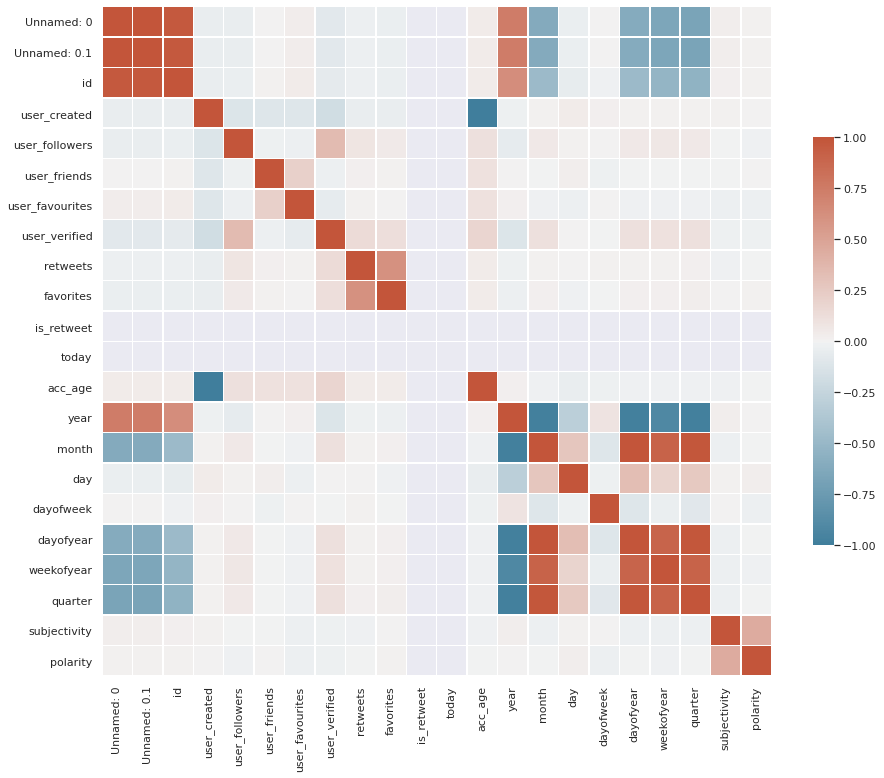

In [26]:
corr = dataframe.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(rc={'figure.figsize':(15,15)})

sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



Categorizando o tamanho dos tweets, a média calculada foi de 77

In [29]:
print(dataframe['corrected_tweet'].apply(len).describe()) # Média 77
dataframe['tweet_length'] = dataframe['corrected_tweet'].apply(lambda x:'short' if len(x)<=77 else 'long')
def categorize_polarity(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

dataframe['sentiment'] = dataframe['polarity'].apply(categorize_polarity)

count    8049.000000
mean       76.651013
std        29.393130
min         3.000000
25%        56.000000
50%        82.000000
75%       100.000000
max       125.000000
Name: corrected_tweet, dtype: float64


Grafico simples apontando a quantidade de sentimento analizado para cada categoria nos Estados Unidos

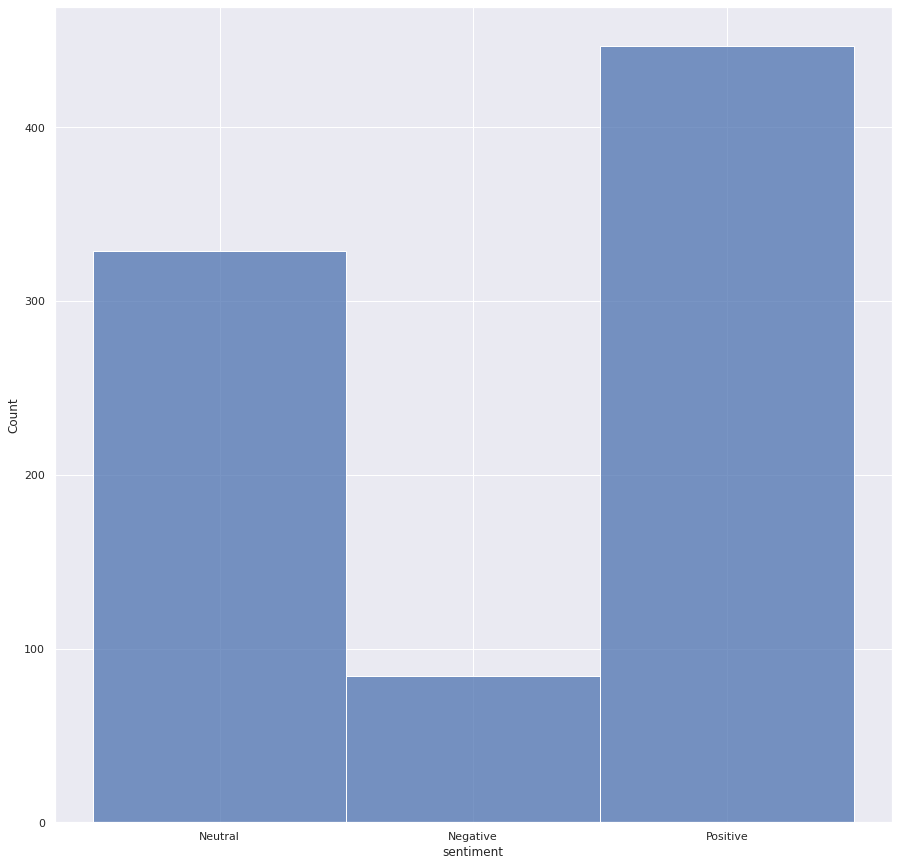

In [31]:
dfCountries = dataframe.filter(items=['second_loc', 'sentiment'])
dfUSA = dfCountries.query("second_loc == 'USA'")
sns.histplot(data = dfUSA, x = "sentiment")

Grafico apontando plotando polaridade x subjetividade

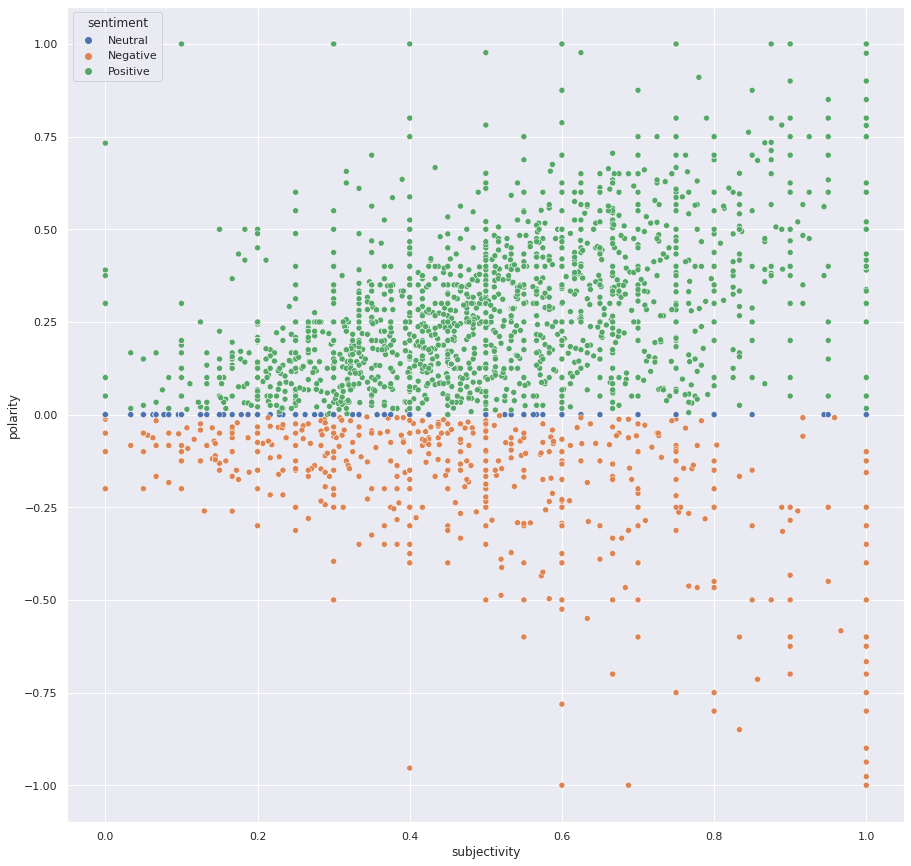

In [33]:
dataframe.groupby('sentiment')['subjectivity'].describe()
sns.scatterplot(x=dataframe['subjectivity'], y=dataframe['polarity'], hue=dataframe['sentiment'])

## CrossTab entre acc_class(Tipo de usuario) pelo sentimento
Aqui vemos que os influencers possuem menor numero de tweets negativos e a porcentagem no seu total segue o mesmo

In [38]:
cross_tab = pd.crosstab(dataframe['acc_class'], dataframe['sentiment'])
cross_tab['total'] = cross_tab['Negative'] + cross_tab['Neutral'] + cross_tab['Positive']
cross_tab['%Negatives'] = cross_tab['Negative'] / cross_tab['total']
cross_tab['%Neutral'] = cross_tab['Neutral'] / cross_tab['total']
cross_tab['%Positive'] = cross_tab['Positive'] / cross_tab['total']
cross_tab

sentiment,Negative,Neutral,Positive,total,%Negatives,%Neutral,%Positive
acc_class,,,,,,,
influencer,73,391,404,868,0.084101,0.450461,0.465438
norm,333,1390,1477,3200,0.104063,0.434375,0.461562
strong,230,979,910,2119,0.108542,0.462010,0.429448
weak,211,799,852,1862,0.113319,0.429108,0.457573


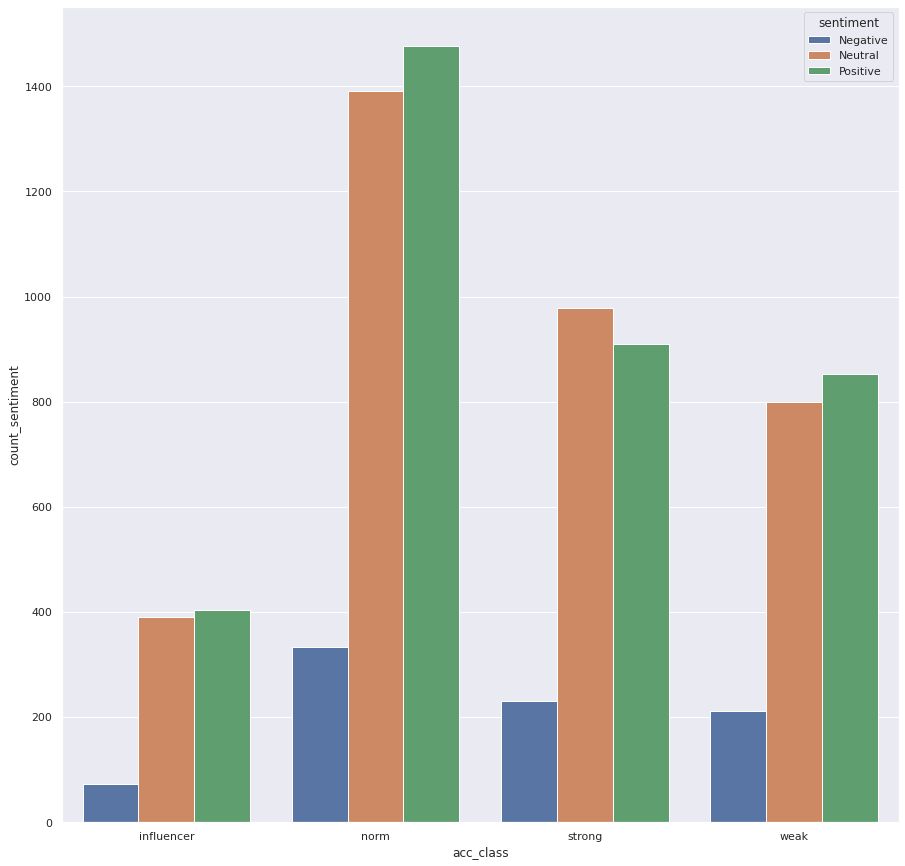

In [48]:
count_sentiment_by_accclass = dataframe.groupby(['acc_class', 'sentiment']).count()['id'].rename('count_sentiment').reset_index()
sns.barplot(data=count_sentiment_by_accclass, x='acc_class', y='count_sentiment', hue='sentiment')

CrossTab entre a idade da conta pelo sentimento analizado

In [ ]:
pd.crosstab(dataframe['acc_age'], dataframe['sentiment'])

sentiment,Negative,Neutral,Positive
acc_age,,,
0,26,63,60
1,88,414,365
2,55,301,298
3,55,193,189
4,47,160,220
5,38,140,162
6,30,172,201
7,51,198,178
8,53,237,223


Apresentamos aqui os top países presentes no dataset e a quantidade de sentimento. Vemos que Canada é o país com maior porcentagem de Negativos

In [43]:
pd.crosstab(dataframe['acc_age'], dataframe['subjectivity'])
dataframe.groupby(['acc_class', 'sentiment'])['subjectivity'].describe()
top_countries = dataframe.groupby('second_loc').count().sort_values('id', ascending=False)[:5].index

dataframe2 = dataframe[dataframe['second_loc'].isin(top_countries)]
cross_tab = pd.crosstab(dataframe2['second_loc'], dataframe2['sentiment'])
cross_tab['total'] = cross_tab['Negative'] + cross_tab['Neutral'] + cross_tab['Positive']
cross_tab['%Negatives'] = cross_tab['Negative'] / cross_tab['total']
cross_tab['%Neutral'] = cross_tab['Neutral'] / cross_tab['total']
cross_tab['%Positive'] = cross_tab['Positive'] / cross_tab['total']
cross_tab.sort_values('total', ascending=False)

sentiment,Negative,Neutral,Positive,total,%Negatives,%Neutral,%Positive
second_loc,,,,,,,
USA,84,329,447,860,0.097674,0.382558,0.519767
UK,51,200,289,540,0.094444,0.370370,0.535185
Canada,24,67,92,183,0.131148,0.366120,0.502732
India,21,71,86,178,0.117978,0.398876,0.483146
Ireland,7,30,53,90,0.077778,0.333333,0.588889


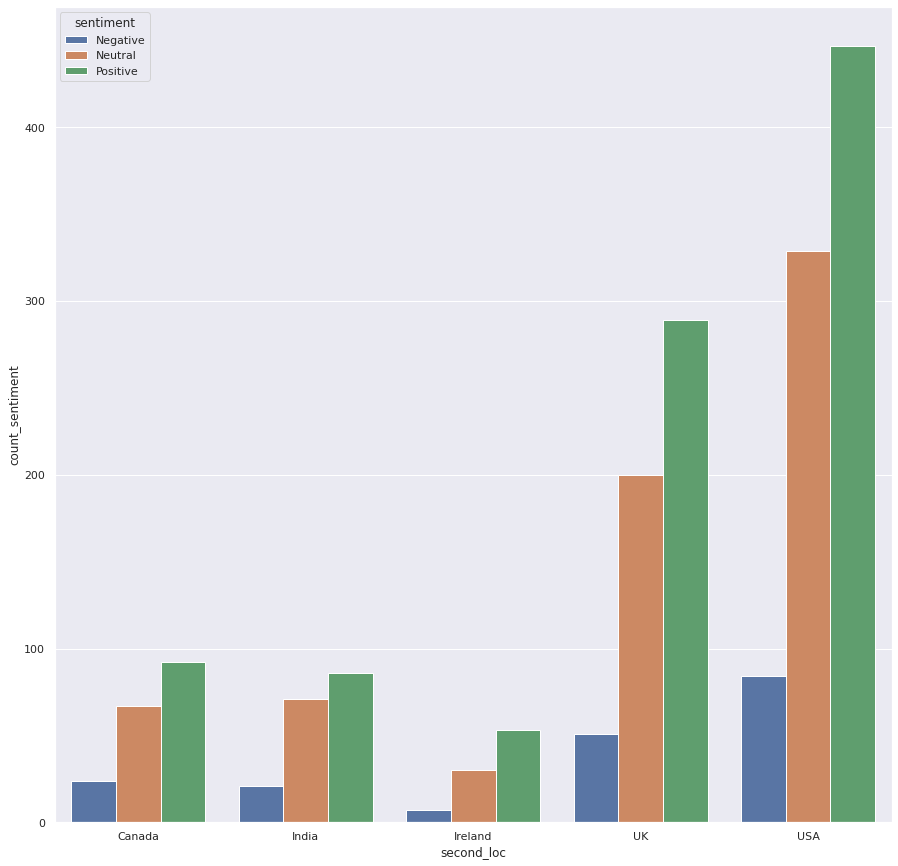

In [46]:
top_countries = dataframe.groupby('second_loc').count().sort_values('id', ascending=False)[:5].index
dataframe2 = dataframe[dataframe['second_loc'].isin(top_countries)]
dataframe2 = dataframe2.groupby(['second_loc', 'sentiment']).count()['id'].rename('count_sentiment').reset_index()
sns.barplot(data=dataframe2, x='second_loc', y='count_sentiment', hue='sentiment')

## Quantidade de engajamento para cada sentimento

Aqui vemos a quantidade de engajamento. Anteriormente apontamos que por exemplo os influencers tinham mais tweets positivos. Porém aqui observamos que embora isso seja uma verdade, seus tweets classificados como neutros tendem a ter um maior engajamento

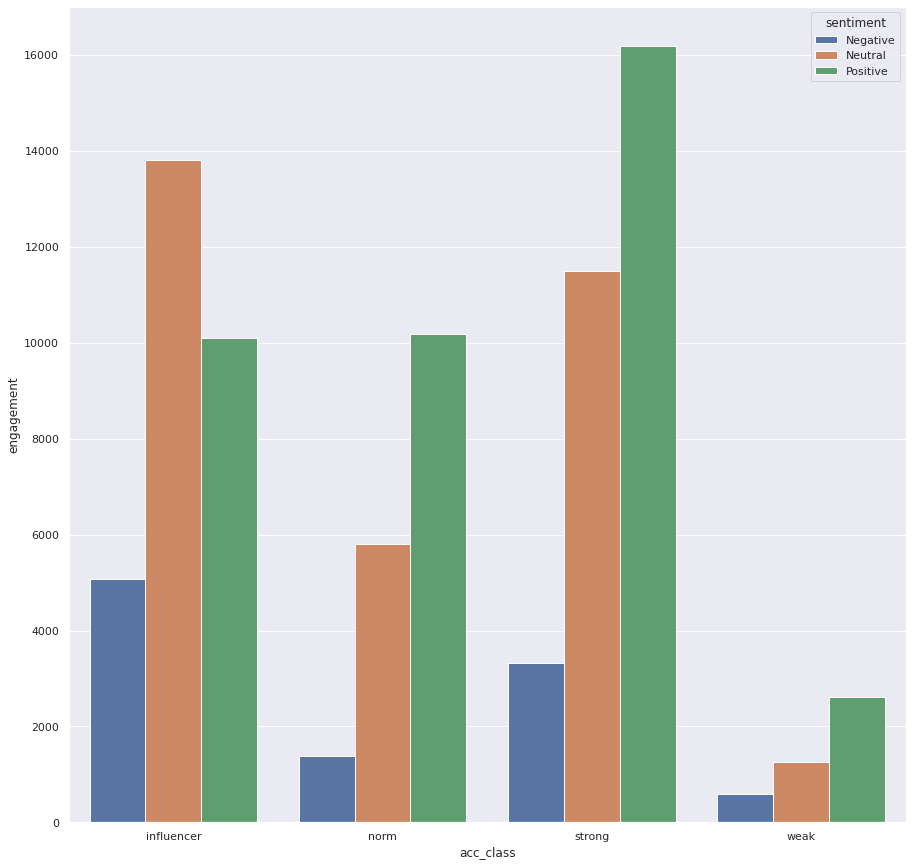

In [44]:
dataframe['engagement'] = dataframe['retweets'] + dataframe['favorites']
total_engagement_by_sentiment = dataframe.groupby(['sentiment', 'acc_class'])['engagement'].sum().reset_index()
sns.barplot(data=total_engagement_by_sentiment, x=total_engagement_by_sentiment.acc_class, y=total_engagement_by_sentiment.engagement, hue='sentiment')